### requirements for the following codings



In [1]:
### working environments and packages required
!pip install fair-esm==2.0.0
!pip install torch==1.13.0+cu116
!pip install pandas==1.3.5
!pip install numpy==1.21.6
!pip install sklearn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.13.0+cu116 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.13.0+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-1.3.5-cp311-cp311-linux_x86_64.whl size=37464019 sha256=97a214732f092edbc33e6e19a0ddf94bda87fdb3de2da50027d146a4be40d956
  Stored in directory: /root/.cache/pip/wheels/8b/e7/6d/d4c288f419ab8fa07c1db6f606a2ae18ecf3dc2839d79a1c07
Successfully built pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully u

### peptide embeddings with esm2_t6_8M_UR50D pretrained models
6 layers, 8M parameters, dataset: UR50/D 2021_04, embedding dimension: 320
mode download URL: https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt

In [3]:
def esm_embeddings(peptide_sequence_list):
  # NOTICE: ESM for embeddings is quite RAM usage, if your sequence is too long,
  #         or you have too many sequences for transformation in a single converting,
  #         you conputer might automatically kill the job.
  import torch
  import esm
  import pandas as pd
  import collections
  # load the model
  # NOTICE: if the model was not downloaded in your local environment, it will automatically download it.
  model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
  batch_converter = alphabet.get_batch_converter()
  model.eval()  # disables dropout for deterministic results

  # load the peptide sequence list into the bach_converter
  batch_labels, batch_strs, batch_tokens = batch_converter(peptide_sequence_list)
  batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
  ## batch tokens are the embedding results of the whole data set

  # Extract per-residue representations (on CPU)
  with torch.no_grad():
      # Here we export the last layer of the EMS model output as the representation of the peptides
      # model'esm2_t6_8M_UR50D' only has 6 layers, and therefore repr_layers parameters is equal to 6
      results = model(batch_tokens, repr_layers=[6], return_contacts=True)
  token_representations = results["representations"][6]

  # Generate per-sequence representations via averaging
  # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
  sequence_representations = []
  for i, tokens_len in enumerate(batch_lens):
      sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
  # save dataset
  # sequence_representations is a list and each element is a tensor
  embeddings_results = collections.defaultdict(list)
  for i in range(len(sequence_representations)):
      # tensor can be transformed as numpy sequence_representations[0].numpy() or sequence_representations[0].to_list
      each_seq_rep = sequence_representations[i].tolist()
      for each_element in each_seq_rep:
          embeddings_results[i].append(each_element)
  embeddings_results = pd.DataFrame(embeddings_results).T
  return embeddings_results

### data loading and embeddings

In [2]:
import numpy as np
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# training dataset loading
dataset = pd.read_excel('/content/drive/MyDrive/Cleaned dataset.xlsx',na_filter = False) # take care the NA sequence problem
sequence_list = dataset['sequences']


In [10]:
# generate the peptide embeddings
sequence_list = dataset['sequences']
embeddings_results = pd.DataFrame()
for seq in sequence_list:
    format_seq = [seq,seq] # the setting is just following the input format setting in ESM model, [name,sequence]
    tuple_sequence = tuple(format_seq)
    peptide_sequence_list = []
    peptide_sequence_list.append(tuple_sequence) # build a summarize list variable including all the sequence information
    # employ ESM model for converting and save the converted data in csv format
    one_seq_embeddings = esm_embeddings(peptide_sequence_list)
    embeddings_results= pd.concat([embeddings_results,one_seq_embeddings])
embeddings_results.to_csv('/content/drive/MyDrive/Cleaned_esm2_t6_8M_UR50D_unified_320_dimension.csv')

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [11]:
# loading the y dataset for model development
y = dataset['label']
y = np.array(y) # transformed as np.array for CNN model

In [12]:
# assign the dataset
X_data_name = '/content/drive/MyDrive/Cleaned_esm2_t6_8M_UR50D_unified_320_dimension.csv'
X = pd.read_csv(X_data_name,header=0,delimiter=',',index_col = 0)
X = np.array(X)

In [13]:
# split dataset as training and test dataset as ratio of 8:2
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=123)

### t-SNE of original dataset

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


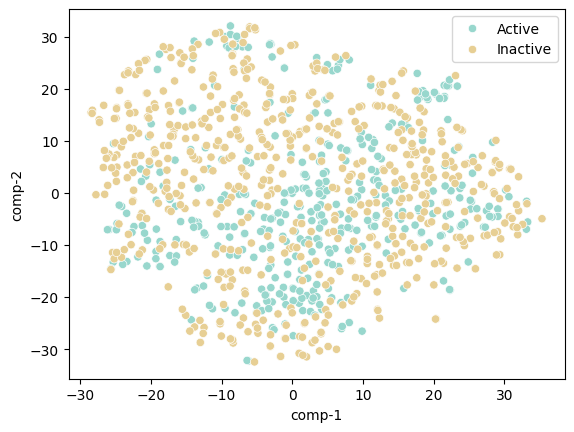

In [14]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 50, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1385_before_CleanLab.png', dpi=600)
df.to_excel('1385_before_CleanLab.xlsx')

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


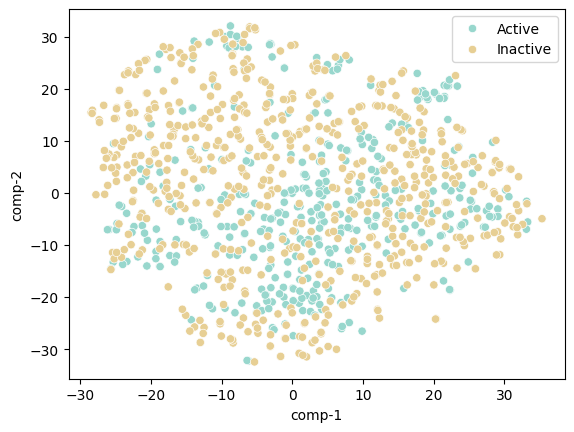

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 50, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1.AHT_t-SNE_1and2.png', dpi=300)
df.to_excel('1.AHT_t-SNE.xlsx')

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


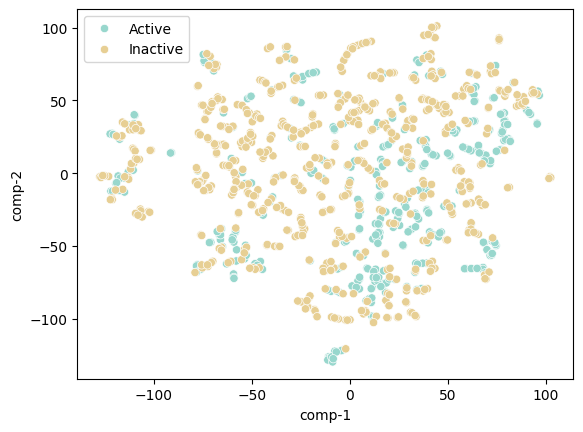

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 5, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1.AHT_t-SNE_1and2.png', dpi=300)
df.to_excel('1.AHT_t-SNE.xlsx')

In [17]:
print(y.shape)
print(X.shape)
print(np.count_nonzero(y==0))
print(np.count_nonzero(y==1))
print(np.count_nonzero(y==2))
print(np.count_nonzero(y==3))

(1020,)
(1020, 320)
394
626
0
0


### CleanLab for data cleaning

In [18]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [19]:
# option 1
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues
from sklearn.linear_model import LogisticRegression
label_issues_info = CleanLearning(clf=LogisticRegression(max_iter=2000)).find_label_issues(X, y)
# find the index of the label
label = label_issues_info['is_label_issue']
label_issue_index=[]
for i in range(label_issues_info.shape[0]):
    if label[i] == True:
        label_issue_index.append(i)

# delete all the wrong labels
X= np.array(X)
y = np.array(y)
# remvoe the highest voted data and the second high voted data
y_new = np.delete(y, label_issue_index,axis=0)
X_new= np.delete(X, label_issue_index,axis=0)

In [20]:
# save numpy array as csv file
from numpy import savetxt
# save to csv file
savetxt('X_Cleaned.csv', X_new, delimiter=',')
savetxt('y_Cleaned.csv', y_new, delimiter=',')

### load CleanLab processed data

In [21]:
# load numpy array from csv file
from numpy import loadtxt
import numpy as np
# load array
X_new = loadtxt('X_Cleaned.csv', delimiter=',')
y_new = loadtxt('y_Cleaned.csv', delimiter=',')

In [22]:
print(X_new.shape)
print(y_new.shape)
print(np.count_nonzero(y_new==0))
print(np.count_nonzero(y_new==1))

(990, 320)
(990,)
380
610


### final dataset profile

In [23]:
# extract all the sequence information of X_new after CleanLab
x_new_seq = []
for i in range(X_new.shape[0]):
    a=0
    for j in range(X.shape[0]):
        if False not in (X_new[i,:] == X[j,:]):
            x_new_seq.append(sequence_list[j])
            a= a+1
            if a ==2:
              print(i,j)
pd.DataFrame(x_new_seq).to_csv('sequence_info_after_CleanLab.csv')

In [24]:
# collect all the sequence length info
len_seq = []
for seq in x_new_seq:
    len_seq.append(len(seq))
# count their number
sum_len_seq = []
for i in range(30):
    sum_len_seq.append(len_seq.count(i+1))
# print the number of each length peptide
sum_len_seq

[0,
 119,
 196,
 128,
 162,
 132,
 59,
 56,
 43,
 33,
 12,
 14,
 12,
 6,
 3,
 4,
 4,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0]

In [25]:
# original dataset distribution

# collect all the sequence length info
len_seq = []
for seq in sequence_list:
    len_seq.append(len(seq))
# count their number
sum_len_seq = []
for i in range(30):
    sum_len_seq.append(len_seq.count(i+1))
# print the number of each length peptide
sum_len_seq

[0,
 122,
 204,
 132,
 164,
 137,
 59,
 59,
 44,
 34,
 12,
 14,
 13,
 7,
 3,
 4,
 4,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0]

### Cross-validation for hyperparameters

In [26]:
import statistics
from sklearn.metrics import balanced_accuracy_score


In [27]:
# dataset splitting
from sklearn.model_selection import train_test_split
X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=1111)

#### logistic regression

In [28]:
# logistic regresion non penality
from sklearn.linear_model import LogisticRegression
acc_cv_mean_collection=[]
C_para = [0.5]
from sklearn.model_selection import StratifiedKFold, KFold
for i in C_para:
    acc_cv_collection = []
    clf = LogisticRegression(penalty= 'None', max_iter = 2000)  # need to tune the hyperparameters
    skf = StratifiedKFold(n_splits=10)
    for train, test in skf.split(X_train_whole, y_train_whole):
        X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                     test.tolist(),
                                                                                                     axis=0), np.take(
            y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
        acc_cv_collection.append(acc_cv)
    acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
    print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'l1', 'l2', 'elasticnet'} or None. Got 'none' instead.

In [ ]:
# logistic regresion l1 penality
from sklearn.linear_model import LogisticRegression
acc_cv_mean_collection=[]
C_para = [0.5,1,1.5,2,2.5,4,6,8,13,14,15,16,20,30,40, 50,60,70, 80, 90 ,100,125]
from sklearn.model_selection import StratifiedKFold, KFold
for i in C_para:
    acc_cv_collection = []
    clf = LogisticRegression(penalty= 'l1', solver= 'saga', C=i, max_iter = 5000)  # need to tune the hyperparameters
    skf = StratifiedKFold(n_splits=10)
    for train, test in skf.split(X_train_whole, y_train_whole):
        X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                     test.tolist(),
                                                                                                     axis=0), np.take(
            y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
        acc_cv_collection.append(acc_cv)
    acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
    print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

LogisticRegression(C=0.5, max_iter=5000, penalty='l1', solver='saga') 0.798 0.048
LogisticRegression(C=1, max_iter=5000, penalty='l1', solver='saga') 0.829 0.044
LogisticRegression(C=1.5, max_iter=5000, penalty='l1', solver='saga') 0.842 0.038
LogisticRegression(C=2, max_iter=5000, penalty='l1', solver='saga') 0.845 0.039
LogisticRegression(C=2.5, max_iter=5000, penalty='l1', solver='saga') 0.861 0.032
LogisticRegression(C=4, max_iter=5000, penalty='l1', solver='saga') 0.888 0.036
LogisticRegression(C=6, max_iter=5000, penalty='l1', solver='saga') 0.898 0.047
LogisticRegression(C=8, max_iter=5000, penalty='l1', solver='saga') 0.897 0.044
LogisticRegression(C=13, max_iter=5000, penalty='l1', solver='saga') 0.899 0.037
LogisticRegression(C=14, max_iter=5000, penalty='l1', solver='saga') 0.9 0.037


In [ ]:
# logistic regresion
from sklearn.linear_model import LogisticRegression
acc_cv_mean_collection=[]
C_para = [0.5,1,1.5,2,2.5,4,6,8,13,14,15,16,20,30,40, 50,60,70, 80, 90 ,100,125, 500, 1000,2000,4000,10000]
from sklearn.model_selection import StratifiedKFold, KFold
for i in C_para:
    acc_cv_collection = []
    clf = LogisticRegression(C=i, max_iter = 5000)  # need to tune the hyperparameters
    skf = StratifiedKFold(n_splits=10)
    for train, test in skf.split(X_train_whole, y_train_whole):
        X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                     test.tolist(),
                                                                                                     axis=0), np.take(
            y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
        acc_cv_collection.append(acc_cv)
    acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
    print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

LogisticRegression(C=0.5, max_iter=5000) 0.812 0.072
LogisticRegression(C=1, max_iter=5000) 0.833 0.063
LogisticRegression(C=1.5, max_iter=5000) 0.833 0.054
LogisticRegression(C=2, max_iter=5000) 0.849 0.046
LogisticRegression(C=2.5, max_iter=5000) 0.854 0.046
LogisticRegression(C=4, max_iter=5000) 0.858 0.044
LogisticRegression(C=6, max_iter=5000) 0.87 0.05
LogisticRegression(C=8, max_iter=5000) 0.877 0.05
LogisticRegression(C=13, max_iter=5000) 0.881 0.043
LogisticRegression(C=14, max_iter=5000) 0.881 0.043
LogisticRegression(C=15, max_iter=5000) 0.881 0.043
LogisticRegression(C=16, max_iter=5000) 0.88 0.041
LogisticRegression(C=20, max_iter=5000) 0.885 0.042
LogisticRegression(C=30, max_iter=5000) 0.89 0.043
LogisticRegression(C=40, max_iter=5000) 0.886 0.047
LogisticRegression(C=50, max_iter=5000) 0.885 0.046
LogisticRegression(C=60, max_iter=5000) 0.885 0.046
LogisticRegression(C=70, max_iter=5000) 0.888 0.044
LogisticRegression(C=80, max_iter=5000) 0.886 0.044
LogisticRegression(

#### random forest

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

acc_cv_mean_collection = []
n_estimatorsint = [80, 160, 320, 480, 640, 1280]
max_depthint = [1, 2, 3, 4]
max_features = ['log2', 'sqrt']

for i in n_estimatorsint:
    for j in max_depthint:
        for p in max_features:
            acc_cv_collection = []
            clf = RandomForestClassifier(n_estimators=i, max_depth=j, max_features=p)
            from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
            skf = StratifiedKFold(n_splits=10)
            for train, test in skf.split(X_train_whole, y_train_whole):
                X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                                test.tolist(),
                                                                                                                axis=0), np.take(
                    y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
                clf.fit(X_train, y_train)
                y_valid_pred = clf.predict(X_valid)
                acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
                acc_cv_collection.append(acc_cv)
            acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
            print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

RandomForestClassifier(max_depth=1, max_features='log2', n_estimators=80) 0.507 0.012
RandomForestClassifier(max_depth=1, max_features='sqrt', n_estimators=80) 0.568 0.041
RandomForestClassifier(max_depth=2, max_features='log2', n_estimators=80) 0.66 0.062
RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=80) 0.677 0.058
RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=80) 0.696 0.076
RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=80) 0.722 0.074
RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=80) 0.718 0.067
RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=80) 0.745 0.074
RandomForestClassifier(max_depth=1, max_features='log2', n_estimators=160) 0.51 0.011
RandomForestClassifier(max_depth=1, max_features='sqrt', n_estimators=160) 0.569 0.041
RandomForestClassifier(max_depth=2, max_features='log2', n_estimators=160) 0.661 0.062
RandomForestClassifier(max_depth=2, max_features='sqr

#### KNN

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

acc_cv_mean_collection = []
n_neighbors = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43]
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [10, 20, 30, 40, 50, 60, 70, 80]
for i in n_neighbors:
    for j in weights:
        for k in algorithm:
            for p in leaf_size:
                acc_cv_collection = []
                clf = KNeighborsClassifier(n_neighbors=i, weights=j, algorithm=k,
                                           leaf_size=p)  # need to tune the hyperparameters
                from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
                skf = StratifiedKFold(n_splits=10)
                for train, test in skf.split(X_train_whole, y_train_whole):
                    X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                                test.tolist(),
                                                                                                                axis=0), np.take(
                        y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
                    clf.fit(X_train, y_train)
                    y_valid_pred = clf.predict(X_valid)
                    acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
                    # print(acc_cv)
                    acc_cv_collection.append(acc_cv)
                acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
                print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

#### SVM

In [ ]:
# LinearSVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

acc_cv_mean_collection = []
C = [0.0001, 0.01, 0.1,  0.5, 1.1, 1.3, 10,20, 30, 40, 50,60, 70, 80, 90, 100, 300]
degree = [1]
tol = [1e-5]
for i in C:
    for k in degree:
        for p in tol:
            acc_cv_collection = []
            clf = LinearSVC(C=i, tol=p, max_iter= 80000)  # need to tune the hyperparameters
            from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
            skf = StratifiedKFold(n_splits=10)
            for train, test in skf.split(X_train_whole, y_train_whole):
                X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                            test.tolist(),
                                                                                                            axis=0), np.take(
                    y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
                clf.fit(X_train, y_train)
                y_valid_pred = clf.predict(X_valid)
                acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
                acc_cv_collection.append(acc_cv)
            acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
            print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

LinearSVC(C=0.0001, max_iter=80000, tol=1e-05) 0.5 0.0
LinearSVC(C=0.01, max_iter=80000, tol=1e-05) 0.772 0.075
LinearSVC(C=0.1, max_iter=80000, tol=1e-05) 0.828 0.055
LinearSVC(C=0.5, max_iter=80000, tol=1e-05) 0.872 0.046
LinearSVC(C=1.1, max_iter=80000, tol=1e-05) 0.878 0.044
LinearSVC(C=1.3, max_iter=80000, tol=1e-05) 0.883 0.045
LinearSVC(C=10, max_iter=80000, tol=1e-05) 0.89 0.041
LinearSVC(C=20, max_iter=80000, tol=1e-05) 0.893 0.041
LinearSVC(C=30, max_iter=80000, tol=1e-05) 0.89 0.041
LinearSVC(C=40, max_iter=80000, tol=1e-05) 0.885 0.039
LinearSVC(C=50, max_iter=80000, tol=1e-05) 0.884 0.037


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=60, max_iter=80000, tol=1e-05) 0.883 0.036


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC(C=70, max_iter=80000, tol=1e-05) 0.887 0.035


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC(C=80, max_iter=80000, tol=1e-05) 0.888 0.036


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC(C=90, max_iter=80000, tol=1e-05) 0.889 0.038


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC(C=100, max_iter=80000, tol=1e-05) 0.892 0.038


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

LinearSVC(C=300, max_iter=80000, tol=1e-05) 0.894 0.042


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# SVM
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

acc_cv_mean_collection = []
C = [0.001, 0.01, 0.1,  0.5, 1.1, 1.3, 5, 10, 30, 50, 100, 300]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1, 3, 5, 7, 9]
tol = [1e-5]
for i in C:
    for j in kernel:
        for k in degree:
            for p in tol:
                acc_cv_collection = []
                clf = SVC(C=i, kernel=j, degree=k)  # need to tune the hyperparameters
                from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
                skf = StratifiedKFold(n_splits=10)
                for train, test in skf.split(X_train_whole, y_train_whole):
                    X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                                test.tolist(),
                                                                                                                axis=0), np.take(
                        y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
                    clf.fit(X_train, y_train)
                    y_valid_pred = clf.predict(X_valid)
                    acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
                    acc_cv_collection.append(acc_cv)
                acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
                print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

SVC(C=0.001, degree=1, kernel='linear') 0.5 0.0
SVC(C=0.001, kernel='linear') 0.5 0.0
SVC(C=0.001, degree=5, kernel='linear') 0.5 0.0
SVC(C=0.001, degree=7, kernel='linear') 0.5 0.0
SVC(C=0.001, degree=9, kernel='linear') 0.5 0.0
SVC(C=0.001, degree=1, kernel='poly') 0.5 0.0
SVC(C=0.001, kernel='poly') 0.5 0.0
SVC(C=0.001, degree=5, kernel='poly') 0.5 0.0
SVC(C=0.001, degree=7, kernel='poly') 0.5 0.0
SVC(C=0.001, degree=9, kernel='poly') 0.5 0.0
SVC(C=0.001, degree=1) 0.5 0.0
SVC(C=0.001) 0.5 0.0
SVC(C=0.001, degree=5) 0.5 0.0
SVC(C=0.001, degree=7) 0.5 0.0
SVC(C=0.001, degree=9) 0.5 0.0
SVC(C=0.001, degree=1, kernel='sigmoid') 0.5 0.0
SVC(C=0.001, kernel='sigmoid') 0.5 0.0
SVC(C=0.001, degree=5, kernel='sigmoid') 0.5 0.0
SVC(C=0.001, degree=7, kernel='sigmoid') 0.5 0.0
SVC(C=0.001, degree=9, kernel='sigmoid') 0.5 0.0
SVC(C=0.01, degree=1, kernel='linear') 0.515 0.018
SVC(C=0.01, kernel='linear') 0.515 0.018
SVC(C=0.01, degree=5, kernel='linear') 0.515 0.018
SVC(C=0.01, degree=7, kerne

#### MLP

In [ ]:
# MLP one layer
from sklearn.neural_network import MLPClassifier

hidden_layers_1 = [1,2,3,4,6,8,12,16, 18, 20, 22, 24,26,28,32, 64, 128, 240, 320, 640,1280]

acc_cv_mean_collection = []
for i in hidden_layers_1:
    acc_cv_collection = []
    clf = MLPClassifier(hidden_layer_sizes=(i,),early_stopping= True,n_iter_no_change= 40, max_iter = 3000)  # need to tune the hyperparameters
    from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
    skf = StratifiedKFold(n_splits=10)
    for train, test in skf.split(X_train_whole, y_train_whole):
        X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                     test.tolist(),
                                                                                                     axis=0), np.take(
            y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
        clf.fit(X_train, y_train)
        y_valid_pred = clf.predict(X_valid)
        y_train_pred = clf.predict(X_train)
        # print(balanced_accuracy_score(y_train, y_train_pred))
        acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
        acc_cv_collection.append(acc_cv)
    acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
    print(clf,round(statistics.mean(acc_cv_collection),3),  round(statistics.stdev(acc_cv_collection),3))

MLPClassifier(early_stopping=True, hidden_layer_sizes=(1,), max_iter=3000,
              n_iter_no_change=40) 0.58 0.134
MLPClassifier(early_stopping=True, hidden_layer_sizes=(2,), max_iter=3000,
              n_iter_no_change=40) 0.666 0.154
MLPClassifier(early_stopping=True, hidden_layer_sizes=(3,), max_iter=3000,
              n_iter_no_change=40) 0.754 0.112
MLPClassifier(early_stopping=True, hidden_layer_sizes=(4,), max_iter=3000,
              n_iter_no_change=40) 0.74 0.113
MLPClassifier(early_stopping=True, hidden_layer_sizes=(6,), max_iter=3000,
              n_iter_no_change=40) 0.771 0.095
MLPClassifier(early_stopping=True, hidden_layer_sizes=(8,), max_iter=3000,
              n_iter_no_change=40) 0.773 0.068
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12,), max_iter=3000,
              n_iter_no_change=40) 0.803 0.05
MLPClassifier(early_stopping=True, hidden_layer_sizes=(16,), max_iter=3000,
              n_iter_no_change=40) 0.821 0.09
MLPClassifier(early_stoppi

In [ ]:
# MLP two layer
from sklearn.neural_network import MLPClassifier

hidden_layers_1 = [12,24,32,64,128,256,320,640,1280]
hidden_layers_2 = [2,8,12,24,32,64,128,256]
acc_cv_mean_collection = []
for i in hidden_layers_1:
    for j in hidden_layers_2:
        acc_cv_collection = []
        clf = MLPClassifier(hidden_layer_sizes=(i,j),early_stopping = True,n_iter_no_change= 40,  max_iter = 3000)  # need to tune the hyperparameters
        from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
        skf = StratifiedKFold(n_splits=10)
        for train, test in skf.split(X_train_whole, y_train_whole):
            X_train, X_valid, y_train, y_valid = np.take(X_train_whole, train.tolist(), axis=0), np.take(X_train_whole,
                                                                                                                    test.tolist(),
                                                                                                                    axis=0), np.take(
            y_train_whole, train.tolist(), axis=0), np.take(y_train_whole, test.tolist(), axis=0)
            clf.fit(X_train, y_train)
            y_valid_pred = clf.predict(X_valid)
            acc_cv = balanced_accuracy_score(y_valid, y_valid_pred)
            acc_cv_collection.append(acc_cv)
        acc_cv_mean_collection.append(round(statistics.mean(acc_cv_collection),3))
        print(clf,round(statistics.mean(acc_cv_collection),3), round(statistics.stdev(acc_cv_collection),3))

MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 2), max_iter=3000,
              n_iter_no_change=40) 0.627 0.168
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 8), max_iter=3000,
              n_iter_no_change=40) 0.821 0.061
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 12), max_iter=3000,
              n_iter_no_change=40) 0.819 0.082
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 24), max_iter=3000,
              n_iter_no_change=40) 0.812 0.078
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 32), max_iter=3000,
              n_iter_no_change=40) 0.824 0.076
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 64), max_iter=3000,
              n_iter_no_change=40) 0.834 0.044
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 128), max_iter=3000,
              n_iter_no_change=40) 0.854 0.065
MLPClassifier(early_stopping=True, hidden_layer_sizes=(12, 256), max_iter=3000,
              n_iter_no_change=40) 0.84

### t-SNE graph
change the perplexity

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


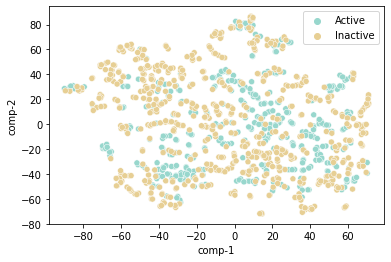

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 10, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X_new)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y_new:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1020 after CleanLab.png', dpi=600)
df.to_excel('1020 after CleanLab.xlsx')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


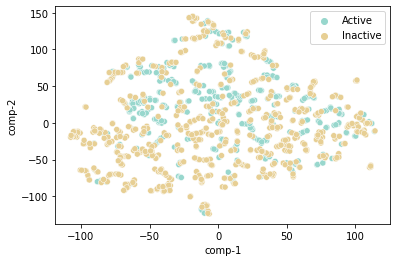

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 5, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X_new)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y_new:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1.AHT_t-SNE_1and2.png', dpi=300)
df.to_excel('1.AHT_t-SNE.xlsx')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


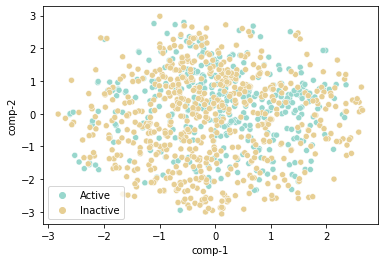

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=0, perplexity= 500, learning_rate='auto',n_iter = 5000,random_state=123)
z = tsne.fit_transform(X_new)
df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
y_new_label=[]
for i in y_new:
    if i == 0:
        y_new_label.append('Active')
    if i == 1:
        y_new_label.append('Inactive')
df["y"] = y_new_label
graph = sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=y_new_label,
                palette='BrBG_r', legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('1.AHT_t-SNE_1and2.png', dpi=300)
df.to_excel('1.AHT_t-SNE.xlsx')

### model development with best hyperparameters

In [ ]:
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import math


In [ ]:
# logistic regression for final test

# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=i)
    # clf = LogisticRegression(penalty= 'none', C=i, max_iter = 2000)
    clf = LogisticRegression(C=2000, max_iter=5000)
    clf.fit(X_train_whole,y_train_whole)# fitting model
    y_pred = clf.predict(X_ind_test)    # predict results
    y_true = y_ind_test                 # asign values for confusiong matrix calculation
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))

print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
# print(round(mean(AUC_collecton),3),'±',round(stdev(AUC_collecton),3))

0.883 ± 0.017
0.845 ± 0.041
0.92 ± 0.025
0.77 ± 0.032


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=i)
    clf = RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=320)
    clf.fit(X_train_whole,y_train_whole)# fitting model
    y_pred = clf.predict(X_ind_test)    # predict results
    y_true = y_ind_test                 # asign values for confusiong matrix calculation
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))

print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
# print(round(mean(AUC_collecton),3),'±',round(stdev(AUC_collecton),3))



0.79 ± 0.03
0.814 ± 0.04
0.765 ± 0.041
0.511 ± 0.062


In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=11, weights='distance')
    clf.fit(X_train_whole,y_train_whole)# fitting model
    y_pred = clf.predict(X_ind_test)    # predict results
    y_true = y_ind_test                 # asign values for confusiong matrix calculation
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))

print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
# print(round(mean(AUC_collecton),3),'±',round(stdev(AUC_collecton),3))



0.748 ± 0.031
0.663 ± 0.033
0.832 ± 0.042
0.505 ± 0.066


In [ ]:
# SVM
from sklearn.svm import SVC
# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=i)
    clf = SVC(C=300, degree=5, kernel='linear')
    clf.fit(X_train_whole,y_train_whole)# fitting model
    y_pred = clf.predict(X_ind_test)    # predict results
    y_true = y_ind_test                 # asign values for confusiong matrix calculation
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))

print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
# print(round(mean(AUC_collecton),3),'±',round(stdev(AUC_collecton),3))



0.867 ± 0.02
0.825 ± 0.041
0.91 ± 0.027
0.74 ± 0.038


In [ ]:
# MLP one layer
from sklearn.neural_network import MLPClassifier
# result collection list
ACC_collecton = []
BACC_collecton = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
for i in range(10):
    # dataset splitting
    X_train_whole, X_ind_test, y_train_whole, y_ind_test =  train_test_split( X_new, y_new, test_size=0.2, random_state=i)
    clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(1280, 32), max_iter=3000, n_iter_no_change=40)
    clf.fit(X_train_whole,y_train_whole)# fitting model
    y_pred = clf.predict(X_ind_test)    # predict results
    y_true = y_ind_test                 # asign values for confusiong matrix calculation
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel() # shape [ [True-Positive, False-positive], [False-negative, True-negative] ]
    Sn_collecton.append(TP/(TP+FN))
    Sp_collecton.append(TN/(TN+FP))
    MCC = (TP*TN-FP*FN)/math.pow(((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),0.5)
    MCC_collecton.append(MCC)
    BACC_collecton.append(0.5*TP/(TP+FN)+0.5*TN/(TN+FP))

print(round(statistics.mean(BACC_collecton),3),'±',round(statistics.stdev(BACC_collecton),3))
print(round(statistics.mean(Sn_collecton),3),'±',round(statistics.stdev(Sn_collecton),3))
print(round(statistics.mean(Sp_collecton),3),'±',round(statistics.stdev(Sp_collecton),3))
print(round(statistics.mean(MCC_collecton),3),'±',round(statistics.stdev(MCC_collecton),3))
# print(round(mean(AUC_collecton),3),'±',round(stdev(AUC_collecton),3))



0.855 ± 0.024
0.815 ± 0.036
0.895 ± 0.037
0.711 ± 0.054
